# **스파크 colab에 환경 구현**

In [1]:
# jdk 툴 설치
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# apache spark download - 하둡 버전에 따라 spakr 와 하둡 변경 (밑에 tgz 파일 설치 및 pip install)
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
# 명령어로 spark - hadoop 파일 압축 풀기
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
# spark 설치
!pip install -q findspark

In [2]:
import os
# spark 환경변수 설정 - java(jdk) ,spark(spark) 2개다 설정해줘야함
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [3]:
#import spark 말고 findspark로 spark파일을 못찾는경우에 빠르게 설치 가능
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

# **MLlib이란?**

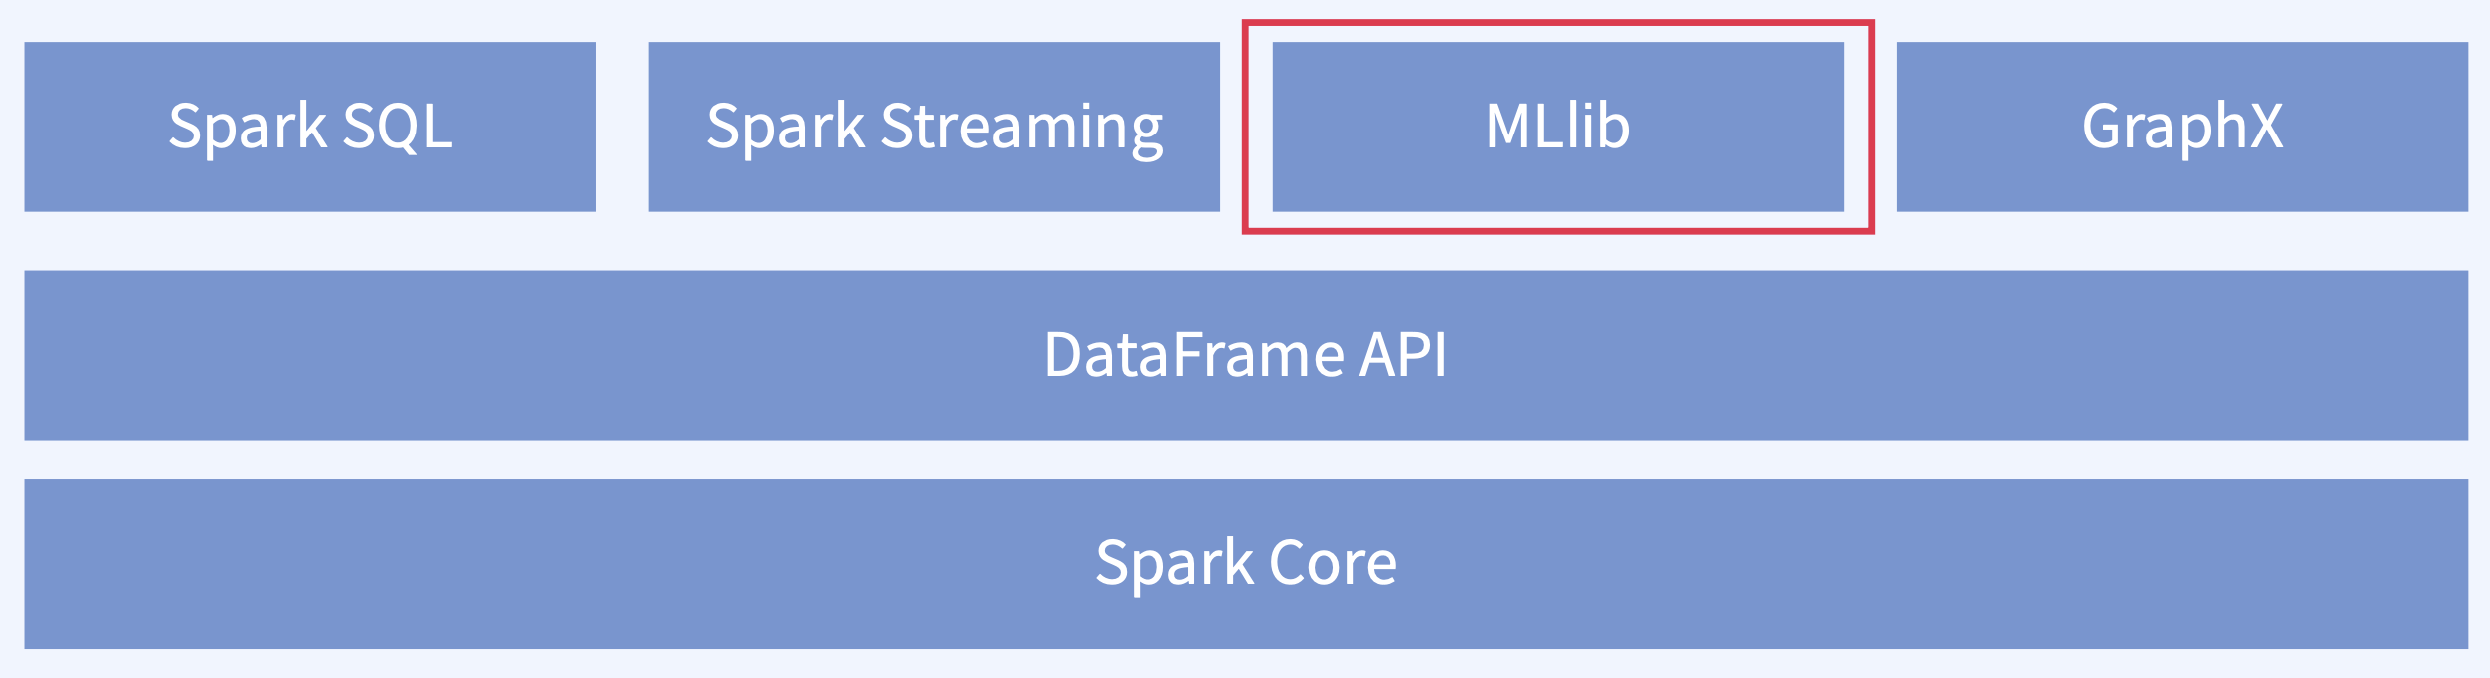

스파크(Spark)의 컴포넌트(Component) 중 하나이며, Machine Learining Library의 약자이며 머신 러닝(Machine Learning)을 쉽고 확장성 있게 적용하고 파이프 라인(Pipeline) 개발을 쉽게 하기 위해 만들어졌다.

스파크에는 여러가지 컴포넌트가 있는데, 데이터 프레임(Dataframe) API 위에서 동작한다.

RDD API는 지원이 끊기는 추세여서 데이터 프레임 API를 이용한다.

데이터 프레임을 쓰는 MLlib API를 스파크 ML로도 부른다.

MLlib으로 가능한 것

피쳐 엔지니어링(Feature Engineering)

통계적 연산

흔히 쓰이는 ML 알고리즘

Regression(Linear, Logistic)

Support Vector Machines

Naive Bayes

Decision Tree

K-Means clustering

추천(Alternating Least Squares) etc...

**MLlib의 컴포넌트**

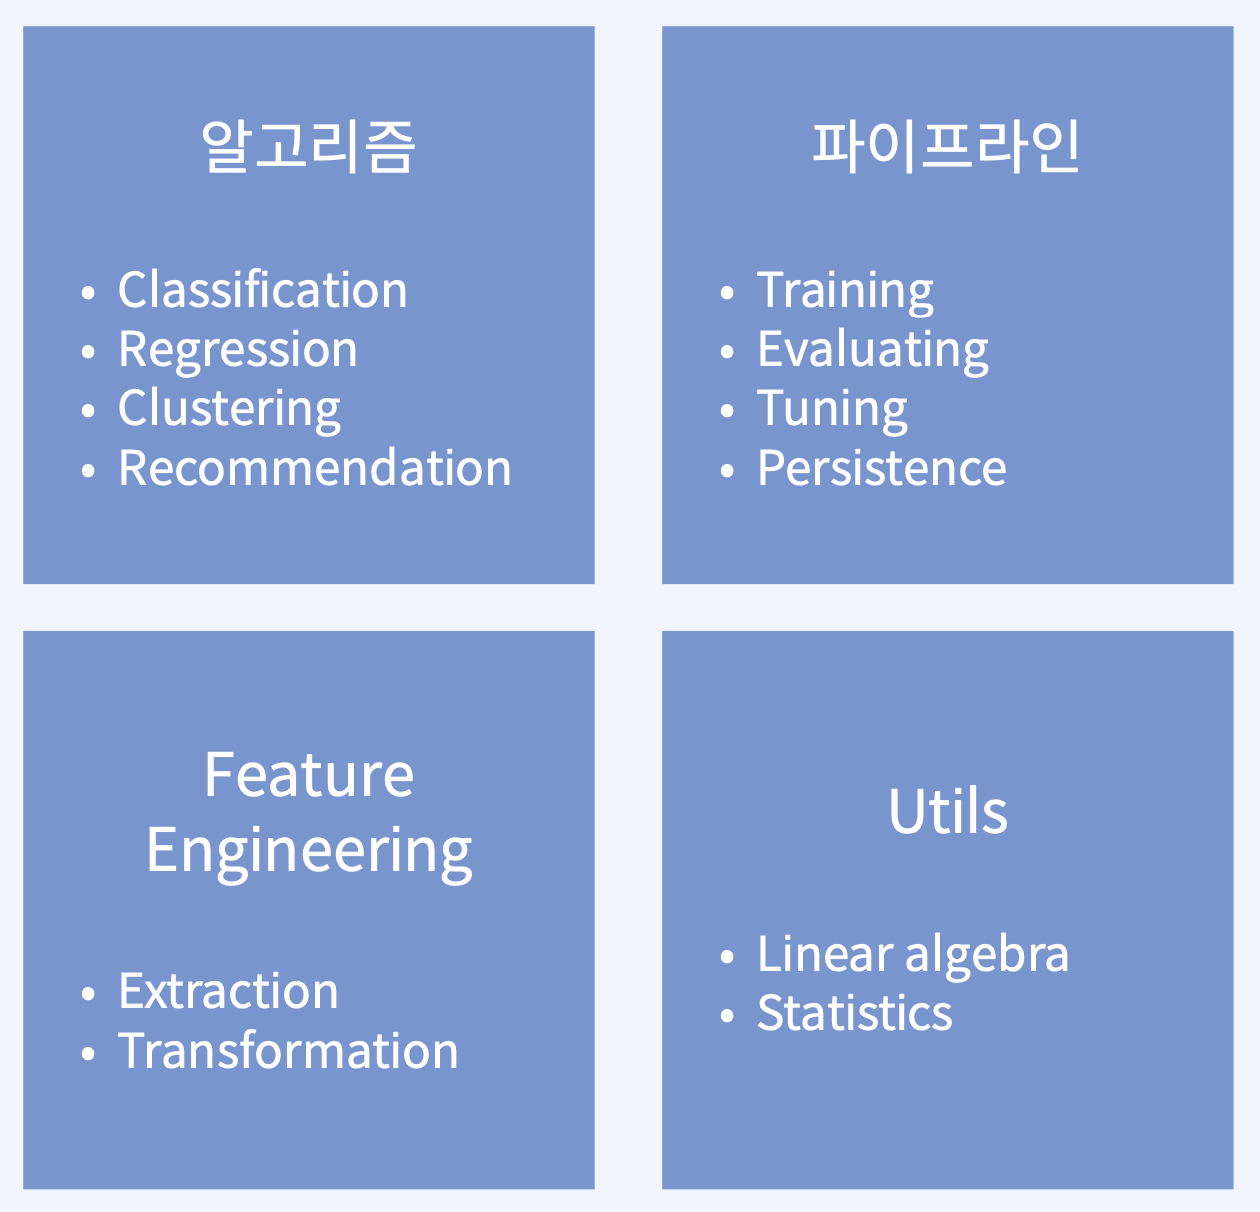

파이프 라인을 만들기 위한 여러가지 컴포넌트가 MLlib에 존재한다.

알고리즘

Classification

Regression

Clustering

Recommendation

파이프라인

Training

Evaluating(평가)

Tuning

Persistence(저장)

Feature Engineering

Extraction

Transformation

Utils

Linear algebra(행렬 계산)

Statistics

**트랜스포머(Transformer)**

피쳐 변환과 학습된 모델을 추상화한다.

모든 트랜스포머 인스턴스는 transform() 함수를 가졌다.

데이터를 학습 가능한 포맷으로 변환한다.

데이터 프레임을 받아 새로운 데이터 프레임을 만드는데, 보통 하나 이상의 컬럼(column)을 더하게 된다.

Data Normalization

Tokenization

One-Hot Encoding

**에스티메이터(Estimatior)**

모델의 학습 과정을 추상화한다.

모든 에스티메이터 인스턴스는 fit() 함수를 가졌다.

fit()은 데이터 프레임을 받아 모델을 반환한다.

모델은 하나의 트랜스포머이다.

lr = LinearRegression()

model = lr.fit(data)

**이밸류에이터(Evaluator)**

매트릭(metric)을 기반으로 모델의 성능을 평가한다.

RMSE(Root mean squared error)

모델을 여러개 만들어서 성능을 평가한 후 가장 좋은 모델을 뽑는 방식으로 튜닝을 자동화할 수 있다.

BinaryClassificationEvaluator

CrossValidator

**파이프라인(Pipeline)** 머신 러닝의 워크 플로우이며, 여러 스테이지를 담고 있고 저장(persist)될 수 있다.

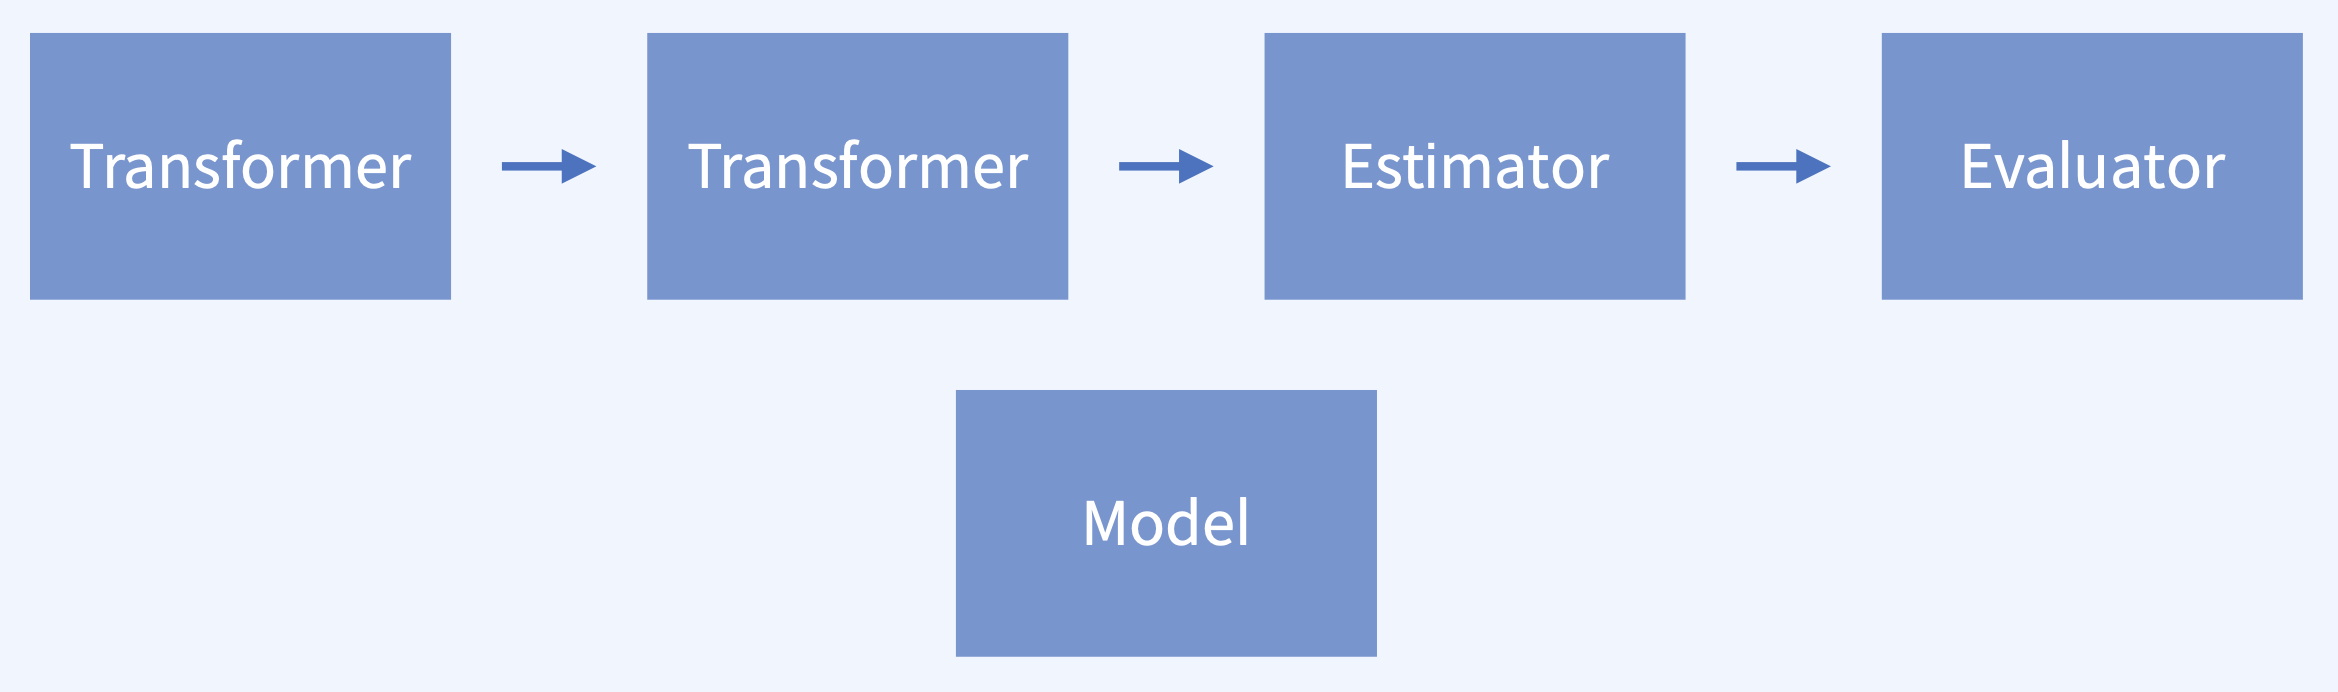

**스파크 머신 러닝**

In [4]:
# 세션과 인스턴스 생성
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local").appName("logistic-regression").getOrCreate()


# 필요한 패키지 불러오기
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression

training = spark.createDataFrame([
    (1.0, Vectors.dense([0.0, 1.1, 0.1])),
    (0.0, Vectors.dense([2.0, 1.0, -1.0])),
    (0.0, Vectors.dense([2.0, 1.3, 1.0])),
    (1.0, Vectors.dense([0.0, 1.2, -0.5]))], ["label", "features"])

training.show()

+-----+--------------+
|label|      features|
+-----+--------------+
|  1.0| [0.0,1.1,0.1]|
|  0.0|[2.0,1.0,-1.0]|
|  0.0| [2.0,1.3,1.0]|
|  1.0|[0.0,1.2,-0.5]|
+-----+--------------+



In [5]:
lr = LogisticRegression(maxIter=30, regParam=0.01) # 로지스틱 리그레션 인스턴스 생성


# 모델 생성
model = lr.fit(training)


In [6]:
# 테스트 데이터 생성
test = spark.createDataFrame([
    (1.0, Vectors.dense([-1.0, 1.5, 1.3])),
    (0.0, Vectors.dense([3.0, 2.0, -0.1])),
    (1.0, Vectors.dense([0.0, 2.2, -1.5]))], ["label", "features"])


# 예측
prediction = model.transform(test)


# 예측 결과
prediction.show()

+-----+--------------+--------------------+--------------------+----------+
|label|      features|       rawPrediction|         probability|prediction|
+-----+--------------+--------------------+--------------------+----------+
|  1.0|[-1.0,1.5,1.3]|[-6.2435552280691...|[0.00193916797132...|       1.0|
|  0.0|[3.0,2.0,-0.1]|[5.45228378434145...|[0.99573179163953...|       0.0|
|  1.0|[0.0,2.2,-1.5]|[-4.4104198106252...|[0.01200422428416...|       1.0|
+-----+--------------+--------------------+--------------------+----------+



**파이프 라인**

파이프 라인을 구성하는 데에 포커스를 맞춘다.

파이프 라인은 데이터의 여러가지 처리 단계를 거칠 때 유용하게 쓰인다.

대표적인 예가 텍스트 데이터로서, 토크나이징이나 글자의 수를 센다던 지 원핫 인코딩을 하는 등의 여러가지 처리 방법이 있다.

In [7]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("logistic-regression").getOrCreate()


from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer


In [8]:
training = spark.createDataFrame([
    (0, "a b c d e spark", 1.0),
    (1, "b d", 0.0),
    (2, "spark f g h", 1.0),
    (3, "hadoop mapreduce", 0.0)
], ["id", "text", "label"])


# 글자를 스플릿하기 위한 토크나이저와 해싱 TF 생성
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")

In [9]:
# 모델 생성
lr = LogisticRegression(maxIter=30, regParam=0.001)


# 파이프라인 생성
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])


# 학습
model = pipeline.fit(training)


# 테스트 데이터 프레임 생성
test = spark.createDataFrame([
    (4, "spark i j k"),
    (5, "l m n"),
    (6, "spark hadoop spark"),
    (7, "apache hadoop")
], ["id", "text"])


# 예측
prediction = model.transform(test)

In [10]:
# 예측 결과
prediction.select(["id", "text", "probability", "prediction"]).show()

+---+------------------+--------------------+----------+
| id|              text|         probability|prediction|
+---+------------------+--------------------+----------+
|  4|       spark i j k|[0.63102692392232...|       0.0|
|  5|             l m n|[0.98489376645228...|       0.0|
|  6|spark hadoop spark|[0.13563146669025...|       1.0|
|  7|     apache hadoop|[0.99563405489777...|       0.0|
+---+------------------+--------------------+----------+

